<a href="https://colab.research.google.com/github/vadim-privalov/Sorevnovania/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D0%B0%D0%BF%D1%80%D0%B5%D0%BB%D1%8C_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Добро** **пожаловать** в апрельский выпуск серии игр Tabular Playground 2022 года! Задача этого месяца — задача классификации временных рядов .

Вам предоставили тысячи шестидесятисекундных последовательностей данных биологических сенсоров, записанных от нескольких сотен участников, которые могли находиться в одном из двух возможных состояний активности. Можете ли вы определить, в каком состоянии находился участник, по данным датчика? Текст, выделенный полужирным шрифтом Текст, выделенный полужирным шрифтом

В этом соревновании вы будете классифицировать 60-секундные последовательности сенсорных данных, указывая, находился ли субъект в одном из двух состояний активности в течение всей последовательности.

Файлы и описания полей
train.csv — обучающий набор, состоящий примерно из 26 000 60-секундных записей тринадцати биологических сенсоров почти для тысячи участников эксперимента.
sequence- уникальный идентификатор для каждой последовательности
subject- уникальный идентификатор субъекта в эксперименте
step- временной шаг записи, с интервалом в одну секунду
sensor_00- sensor_12- значение для каждого из тринадцати датчиков на этом временном шаге
train_labels.csv — метка класса для каждой последовательности.
sequence- уникальный идентификатор для каждой последовательности.
state- состояние, связанное с каждой последовательностью. Это цель, которую вы пытаетесь предсказать.
test.csv - тестовый набор. Для каждой из примерно 12 000 последовательностей вы должны предсказать значение state.
sample_submission.csv — образец файла отправки в правильном формате.

In [ ]:
import numpy as np # модуль для загрузки файлов в colab
import pandas as pd #библиотека для работы с таблицами pandas
from google.colab import files #библиотека для работы с массивами данных
import json

from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.utils import plot_model, get_file, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import csv # импортируем модуль для удобной работы с файлами
import matplotlib as mpl
import matplotlib.pyplot as plt #Отрисовка изображений
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from google.colab import files

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import zipfile # для работы с архивами zip

import os
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time, logging, gc
from sklearn.preprocessing import RobustScaler, StandardScaler

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt 

Загружаем данные

In [ ]:
train = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-apr-2022/train.csv",
                           sep = ',')
train

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


In [ ]:
test = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-apr-2022/test.csv",
                           sep = ',')
test

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.00000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.00000,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.00000,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.00000,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.00000,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.211747,2.005252,-1.33282,0.695575,-0.161327,-1.193717,0.421676,0.869466,0.0,-1.536850,0.388101,2.205761,-91.610827
733076,38185,773,56,-0.826121,-2.468487,-1.33282,0.381416,0.144745,1.060583,-0.765938,0.288550,0.2,-1.956647,-0.032158,-1.794239,72.414749
733077,38185,773,57,0.755023,1.469538,-1.33282,-1.253097,-0.414802,0.007479,0.907104,-1.556489,0.4,4.341763,0.150273,0.641975,-34.065644
733078,38185,773,58,-0.187017,0.714286,-1.33282,0.077876,1.323245,0.159312,-0.397996,0.306870,0.1,-1.013728,-0.608616,0.317901,65.659420


In [ ]:
labels = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-apr-2022/train_labels.csv",
                           sep = ',')
labels

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


In [ ]:
submission = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-apr-2022/sample_submission.csv",
                           sep = ',')
submission

,sequence,state
0,25968,0.98700
1,25969,0.95560
2,25970,0.01706
3,25971,0.82570
4,25972,0.74200
...,...,...
12213,38181,0.26100
12214,38182,0.72500
12215,38183,0.53660
12216,38184,0.03378


In [ ]:
# Вариант 2
def create_new_features(df):
    df['sensor_02_num'] = df['sensor_02'] > -15
    df['sensor_02_num'] = df['sensor_02_num'].astype(int)
    df['sensor_sum1'] = (df['sensor_00'] + df['sensor_09'] + df['sensor_06'] + df['sensor_01'])
    df['sensor_sum2'] = (df['sensor_01'] + df['sensor_11'] + df['sensor_09'] + df['sensor_06'] + df['sensor_00'])
    df['sensor_sum3'] = (df['sensor_03'] + df['sensor_11'] + df['sensor_07'])
    df['sensor_sum4'] = (df['sensor_04'] + df['sensor_10'])
    
    sensors = ['sensor_'+'%02d'%i for i in range(0, 13)]
    sensors.extend(['sensor_02_num', 'sensor_sum1', 'sensor_sum2', 'sensor_sum3', 'sensor_sum4'])
    
    for sensor in sensors:
        df[sensor + '_lag1'] = df.groupby('sequence')[sensor].shift(1)
        df.fillna(0, inplace=True)
        df[sensor + '_diff1'] = df[sensor] - df[sensor + '_lag1'] 
    
    return df

In [ ]:
# Вариант 2
train = create_new_features(train)
test = create_new_features(test)

In [ ]:
# вариант 2
# добавление меток к обучающим данным
train = pd.merge(train, labels,how='left', on="sequence")

In [ ]:
# Dfhbyn 2
Window = 60

In [ ]:
# Вариант 2
# Выделяем целевую переменную, удаляем их обучающей и тестоовой выборки не нужные столбцы
y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)

In [ ]:
# Вариант 2
# Нормализвция данных
sc = StandardScaler()

sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

In [ ]:
# Вариант 2
train = train.reshape(-1, Window, train.shape[-1])
test = test.reshape(-1, Window, train.shape[-1])

In [ ]:
# Вариант 2
train.shape

(25968, 60, 54)

In [ ]:
# Вариант 2
test.shape

(12218, 60, 54)

Далее по варианту 2 можно переходить к нашим моделям. Все что ниже это ВАариант 1


Проверяем наши данные

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733080 entries, 0 to 733079
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   733080 non-null  int64  
 1   subject    733080 non-null  int64  
 2   step       733080 non-null  int64  
 3   sensor_00  733080 non-null  float64
 4   sensor_01  733080 non-null  float64
 5   sensor_02  733080 non-null  float64
 6   sensor_03  733080 non-null  float64
 7   sensor_04  733080 non-null  float64
 8   sensor_05  733080 non-null  float64
 9   sensor_06  733080 non-null  float64
 10  sensor_07  733080 non-null  float64
 11  sensor_08  733080 non-null  float64
 12  sensor_09  733080 non-null  float64
 13  sensor_10  733080 non-null  float64
 14  sensor_11  733080 non-null  float64
 15  sensor_12  733080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 89.5 MB


In [ ]:
# Выделяем столбцы с описательными признаками
features  = [col for col in test.columns if col not in ("sequence","step","subject")]

In [ ]:
train[features].describe() 

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02
std,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01
min,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02
25%,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01
50%,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00
75%,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01
max,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02


In [ ]:
# добавление меток к обучающим данным
train = pd.merge(train, labels,how='left', on="sequence")

In [ ]:
# Данные за первые 60 секунд
train[train['sequence']==0]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0
5,0,47,5,-1.073416,-1.714286,1.000000,-1.492920,0.469736,0.713538,-1.792350,-1.082443,-0.5,0.314306,0.664594,-1.682099,-2.838448,0
6,0,47,6,0.350850,0.439076,1.000000,0.870796,-0.596964,0.923710,0.769581,0.666412,0.2,-0.723266,-1.691552,0.842593,1.849531,0
7,0,47,7,-0.304482,-0.379202,1.000000,-0.218584,-0.059983,-1.389678,-0.182149,-0.029771,0.1,-0.070809,-0.774024,-0.612140,3.300938,0
8,0,47,8,-0.216383,1.106092,1.000000,0.677876,-0.071718,-0.456993,0.296903,0.111450,0.6,-0.525289,-0.334069,1.751029,0.515772,0
9,0,47,9,0.303709,-1.744748,1.000000,-0.896460,-0.755221,-0.254301,-0.354281,-0.591603,0.0,0.151012,-0.268359,-2.033951,4.509378,0


**Разработка функций**

In [ ]:
def addFeatures(df):  
    return df

train = addFeatures(train)
test = addFeatures(test)

In [ ]:
Window = 60

In [ ]:
# Выделяем целевую переменную, удаляем их обучающей и тестоовой выборки не нужные столбцы
y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)

In [ ]:
# Нормализвция данных
sc = StandardScaler()

sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

In [ ]:
train = train.reshape(-1, Window, train.shape[-1])
test = test.reshape(-1, Window, train.shape[-1])

In [ ]:
train.shape

(25968, 60, 13)

In [ ]:
# Обнаружение оборудования, возврат соответствующей стратегии распространения
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.8.0
Mixed precision enabled
REPLICAS:  1


**Модель**

In [ ]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# Вариант 1
def createModel():   
    with strategy.scope():
    
        model = Sequential([
            
            Input(shape=(Window, train.shape[-1])),
            Bidirectional(LSTM(1028, return_sequences=True)),
            Bidirectional(LSTM(512, return_sequences=True)),
            Bidirectional(LSTM(256, return_sequences=True)),
            Bidirectional(LSTM(128, return_sequences=True)),
            Dense(128, activation='selu'),
            Dense(1, activation="sigmoid")
        ])

        model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    return(model)

In [ ]:
# Вариант 2
def createModel():   
    with strategy.scope():
    
        model = Sequential([
            
            Input(shape=(Window, train.shape[-1])),
            Bidirectional(LSTM(1028, return_sequences=True)),
            SpatialDropout1D(0.2),
            #Bidirectional(GRU(512, return_sequences=True)),
            Bidirectional(LSTM(512, return_sequences=True)),
            Bidirectional(LSTM(256, return_sequences=True)),
            Bidirectional(LSTM(128, return_sequences=True)),
            Dense(128, activation='selu'),
            Dense(1, activation="sigmoid")
        ])

        model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    return(model)

****** fold: 1 *******
Epoch 1/40
51/51 [==============================] - 233s 4s/step - loss: 0.6576 - auc: 0.6549 - val_loss: 0.5751 - val_auc: 0.7749
Epoch 2/40
51/51 [==============================] - 196s 4s/step - loss: 0.5668 - auc: 0.7773 - val_loss: 0.5427 - val_auc: 0.8062
Epoch 3/40
51/51 [==============================] - 194s 4s/step - loss: 0.4853 - auc: 0.8453 - val_loss: 0.4424 - val_auc: 0.8768
Epoch 4/40
51/51 [==============================] - 194s 4s/step - loss: 0.4295 - auc: 0.8828 - val_loss: 0.4199 - val_auc: 0.8954
Epoch 5/40
51/51 [==============================] - 193s 4s/step - loss: 0.3915 - auc: 0.9044 - val_loss: 0.4431 - val_auc: 0.8865
Epoch 6/40
51/51 [==============================] - 194s 4s/step - loss: 0.3529 - auc: 0.9229 - val_loss: 0.3775 - val_auc: 0.9161
Epoch 7/40
51/51 [==============================] - 193s 4s/step - loss: 0.3084 - auc: 0.9417 - val_loss: 0.3444 - val_auc: 0.9315
Epoch 8/40
51/51 [==============================] - 193s 4s/

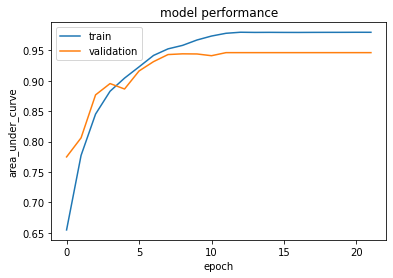

****** fold: 2 *******
Epoch 1/40
51/51 [==============================] - 223s 4s/step - loss: 0.6886 - auc: 0.5835 - val_loss: 0.6510 - val_auc: 0.6795
Epoch 2/40
51/51 [==============================] - 228s 4s/step - loss: 0.6051 - auc: 0.7339 - val_loss: 0.5518 - val_auc: 0.8062
Epoch 3/40
51/51 [==============================] - 194s 4s/step - loss: 0.4984 - auc: 0.8356 - val_loss: 0.4709 - val_auc: 0.8606
Epoch 4/40
51/51 [==============================] - 193s 4s/step - loss: 0.4392 - auc: 0.8778 - val_loss: 0.4265 - val_auc: 0.8898
Epoch 5/40
51/51 [==============================] - 193s 4s/step - loss: 0.3792 - auc: 0.9107 - val_loss: 0.3783 - val_auc: 0.9204
Epoch 6/40
51/51 [==============================] - 193s 4s/step - loss: 0.3552 - auc: 0.9222 - val_loss: 0.3748 - val_auc: 0.9199
Epoch 7/40
51/51 [==============================] - 194s 4s/step - loss: 0.3070 - auc: 0.9422 - val_loss: 0.3352 - val_auc: 0.9323
Epoch 8/40
51/51 [==============================] - 194s 4s/

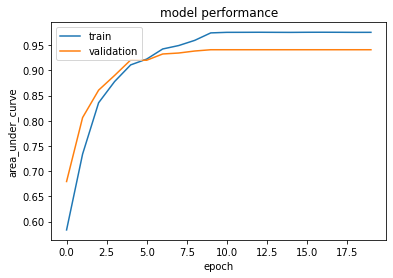

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)

test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(train, y)):
    print(f"****** fold: {fold+1} *******")
    X_train, X_valid = train[train_idx], train[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=1,restore_best_weights=True)
    
    model = createModel()
        
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=40, batch_size = 256, callbacks = [es])
    test_preds.append(model.predict(test).squeeze())
    plotHist(history)
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()  

**Submission**

In [ ]:
submission["state"] = sum(test_preds)/kf.n_splits 
submission.to_csv('submission.csv', index=False)
submission 

,sequence,state
0,25968,0.982910
1,25969,0.989746
2,25970,0.017166
3,25971,0.770508
4,25972,0.594238
...,...,...
12213,38181,0.113647
12214,38182,0.940430
12215,38183,0.127930
12216,38184,0.234863


# Новый раздел

In [ ]:
sample_submission = submission.to_csv('/content/drive/MyDrive/my_databases/tabular-playground-series-apr-2022/sample_submission.csv', sep=',', index=False, header=True)